In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sys
import scipy.stats
import matplotlib.pyplot as pl

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/nd/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'randint']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [7]:
%%javascript

// this adds a shortcut for "run all cells" (not enabled by default) to Ctl+m, r
Jupyter.keyboard_manager.command_shortcuts.add_shortcut('r', {
    help : 'run all cells',
    help_index : 'zz',
    handler : function (event) {
        IPython.notebook.execute_all_cells();
        return false;
    }}
);

<IPython.core.display.Javascript object>

In [8]:
"""
This Module handles all aspects of student modeling and assessment
"""
from random import randint
import numpy as np

class StudentModel():
    """
    This class implements a Gaussian Process, intended to model student vocabulary knowledge
    It uses a kernel based on the distance between two words in ConceptNet as well as a
    phonetic distance heuristic
    """

    def __init__(self):
        #fancy python one-liner to read all string attributes off of a class
        self.curriculum = ['BEE','CHICKEN','MONKEY','RABBIT','ROOSTER','SHEEP','TIGER','SNAKE']

    def init_model(self):
        """
        sets up the GP and kernel
        """


    def get_prior(self, n_samples):
        """
        Samples form a prior distribution over the words
        """

        # Test data
        # we only care about evaluating the GP at this finite collection of points
        x_test = self.curriculum

        cov_ss = self.concept_net_kernel(x_test,x_test) #the Kernel Matrix for the words
        print(cov_ss)

        # Get cholesky decomposition (square root) of the
        # covariance matrix
        chol_matrix = np.linalg.cholesky(cov_ss + 1e-15 * np.eye(len(x_test)))

        # Sample 3 sets of standard normals for our test points,
        # multiply them by the square root of the covariance matrix
        f_prior = np.dot(chol_matrix, np.random.normal(size=(len(x_test), n_samples)))
        return f_prior



    def get_next_best_word(self):
        """
        gives an external caller the next best word to achieve some objective
        Active Learning paradigm should be implemented here!
        """
        return self.curriculum[randint(0, len(self.curriculum) - 1)] #randint is inclusive

    def add_data_point(self, word_asked, answered_correct):
        """
        allows external controller to update the GP with new data
        """
        print(self)
        print('answered ' + word_asked+ ('in' if not answered_correct else '') + 'correctly')

    def concept_net_kernel(self, word_set_a, word_set_b):
        """
        Implements a conceptnet based covariance matrix
        """
        #k = np.empty((len(word_set_a), len(word_set_b),))

        #first, validate that these are all words in our curriculum
        for elem in set().union(word_set_a, word_set_b):
            if not elem in self.curriculum:
                raise Exception(elem + ' is not a word in our curriculum')

        k = np.ones((len(word_set_a), len(word_set_b)))
        for i in range(len(word_set_a)):
            for j in range(len(word_set_b)):
                k[i][j] = self.get_word_cov(word_set_a[i], word_set_b[j])
                
        return k
    
    def get_word_cov(self, word_a, word_b):
        """
        Currently, just implements a letter counting distance metric.
        Will eventually incorporate conceptnet and other phonetic metrics
        """

        if (word_a == word_b):
            return 1

        score = 0
        for letter_a in word_a:
            if letter_a in word_b:
                score += 1
                
        for letter_b in word_b:
            if letter_b in word_a:
                score += 1
                        
        ratio = (score / (len(word_a) + len(word_b)))
        return round(ratio, 2)




[[ 1.    0.3   0.33  0.33  0.3   0.5   0.38  0.38]
 [ 0.3   1.    0.46  0.15  0.14  0.42  0.33  0.5 ]
 [ 0.33  0.46  1.    0.    0.38  0.27  0.18  0.55]
 [ 0.33  0.15  0.    1.    0.38  0.    0.55  0.18]
 [ 0.3   0.14  0.38  0.38  1.    0.42  0.58  0.33]
 [ 0.5   0.42  0.27  0.    0.42  1.    0.3   0.5 ]
 [ 0.38  0.33  0.18  0.55  0.58  0.3   1.    0.2 ]
 [ 0.38  0.5   0.55  0.18  0.33  0.5   0.2   1.  ]]


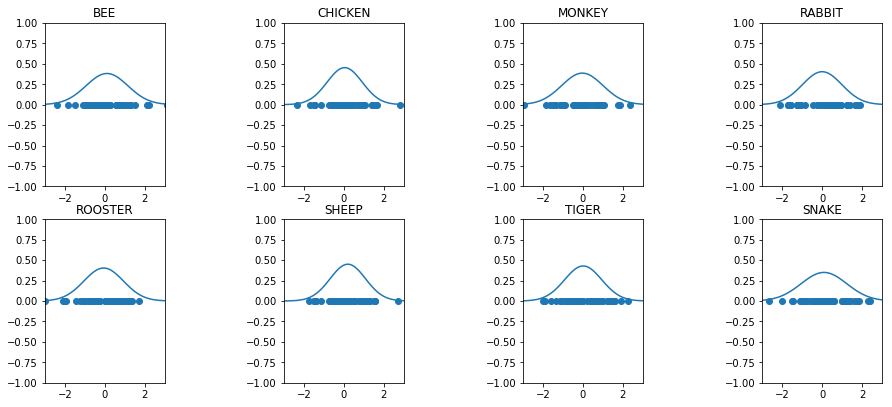

In [9]:
msm = StudentModel()

test_space_size = len(msm.curriculum)
n_samples = 50
n_rows = 2

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.4   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 1.0   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots

f_prior = msm.get_prior(n_samples)
#print(f_prior)

#f, plts = plt.subplots(n_rows, int(test_space_size / n_rows), sharex='col', sharey='row', figsize=(15,10))
f, plts = plt.subplots(n_rows, int(test_space_size / n_rows), figsize=(15,10))
#print(plts)

for i in range(test_space_size):
    row_index = int(i / (test_space_size * .5))
    col_index = int(i % (test_space_size / n_rows))
    plts[row_index][col_index].set_xlim([-3, 3])
    plts[row_index][col_index].set_ylim([-1, 1])
    
    data = f_prior[:][i]
    plts[row_index][col_index].scatter(data, np.zeros(n_samples))
    
    variance = 1
    x = np.linspace(-3,3, 50)
    plts[row_index][col_index].plot(x,mlab.normpdf(x, np.mean(data), np.var(data)))    
    plts[row_index][col_index].set_title(msm.curriculum[i])
    
subplots_adjust(left, bottom, right, top, wspace, hspace)

#     plts[0][0].set_title('Sharing x per column, y per row')
#     plts[0][1].scatter(x, y)
#     plts[1][0].scatter(x, 2 * y ** 2 - 1, color='r')
#     plts[1][1].plot(x, 2 * y ** 2 - 1, color='r')

[ 0.99997586  0.70959004  0.65603691  0.65603691  0.76402157  0.78575347
  0.99996598  0.99996598]
[ 0.00707084  0.83251956  0.82434519  0.82434519  0.7846833   0.79260123
  0.00707086  0.00707086]
BEE
0.999564506677
5.2163437767e-05
0.999975856185
4.99967078987e-05
CHICKEN
0.850396704876
0.526135424369
0.709590038764
0.69308881727
MONKEY
0.68036713373
0.737696193607
0.656036912093
0.679544989389
RABBIT
0.687678368202
0.69833098741
0.656036912093
0.679544989389
ROOSTER
0.793895065039
0.424826222993
0.764021571244
0.615727882089
SHEEP
0.926452515054
0.508038352634
0.78575347361
0.628216715168
TIGER
1.00067608405
5.59920195167e-05
0.999965980292
4.99970658774e-05
SNAKE
0.999633261521
5.02085561281e-05
0.999965980292
4.99970658775e-05


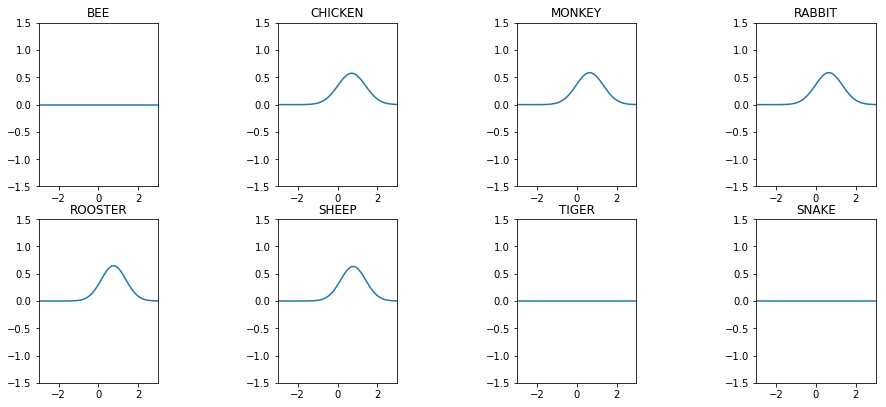

In [12]:
Xtrain = ['BEE', 'SNAKE', 'TIGER'] # these numbers are just labels
Ytrain = [1,1,1] # these numbers correspond to 'Correct' demonstrations

Xtest = msm.curriculum # these numbers are just labels
cov_ss = msm.concept_net_kernel(Xtest, Xtest)

# Apply the kernel function to our training points
K = msm.concept_net_kernel(Xtrain, Xtrain)
L = np.linalg.cholesky(K + 0.00005*np.eye(len(Xtrain)))

# Compute the mean at our test points.
K_s = msm.concept_net_kernel(Xtrain, Xtest)
Lk = np.linalg.solve(L, K_s)
mu = np.dot(Lk.T, np.linalg.solve(L, Ytrain)).reshape((test_space_size,))



# Compute the standard deviation so we can plot it
s2 = np.diag(cov_ss) - np.sum(Lk**2, axis=0)
stdv = np.sqrt(s2)

print(mu)
print(stdv)

# Draw samples from the posterior at our test points.
L = np.linalg.cholesky(cov_ss + 1e-6*np.eye(test_space_size) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(test_space_size, n_samples)))

#f, plts = plt.subplots(n_rows, int(test_space_size / n_rows), sharex='col', sharey='row', figsize=(15,10))
f, plts = plt.subplots(n_rows, int(test_space_size / n_rows), figsize=(15,10))
#print(plts)

for i in range(test_space_size):
    row_index = int(i / (test_space_size * .5))
    col_index = int(i % (test_space_size / n_rows))
    plts[row_index][col_index].set_xlim([-3, 3])
    plts[row_index][col_index].set_ylim([-1.5, 1.5])
    
    data = f_post[:][i]
    print(msm.curriculum[i])
    print(np.mean(data))
    print(np.var(data))
    print(mu[i])
    print(s2[i])
    #plts[row_index][col_index].scatter(data, np.zeros(n_samples))
    
    variance = 1
    x = np.linspace(-3,3, 50)
    plts[row_index][col_index].plot(x, scipy.stats.norm.pdf(x, mu[i], s2[i]))    
    plts[row_index][col_index].set_title(msm.curriculum[i])
    
subplots_adjust(left, bottom, right, top, wspace, hspace)
